In [19]:
import numpy as np

from keras.datasets import imdb
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

import matplotlib.pyplot as plt

In [2]:
# to avoid a cuBLAS error, per https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load and look at input data - movie reviews

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((25000,), (25000,), (25000,), (25000,))

In [4]:
len(train_data[0])

218

Each element in train_data is a review, represented as a list of numbers where each number is the index of a word. See below a bit for mapping backwards from index to word.

In [5]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [6]:
len(train_labels)

25000

The label is the sentiment of the review: positive is 1 and negative is 0. 

In [7]:
train_labels[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

No particular word index is going to be greater than 9999 because we've restricted ourselves to only the top 10K most common words (above, when we loaded the data).

In [8]:
max([max(sequence) for sequence in train_data])

9999

In [9]:
word_index = imdb.get_word_index() # a dict mapping words to an integer index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [10]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]]) # 0,1,2 are reserved indices a few
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# Encode reviews as tensors

Page 69 talks about two different representations, and goes with a one-hot encoded transformation, so that each review is a vector of size 10K (since we have 10K possible words) with 0 if the word doesn't exist in the review and 1 if the word exists (one or more times). 

In [11]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

x_train.shape, x_test.shape

((25000, 10000), (25000, 10000))

In [12]:
x_train[0], sum(x_train[0]), len(train_data[0])

(array([0., 1., 1., ..., 0., 0., 0.]), 120.0, 218)

Also vectorize the labels... I think because Keras wants them as numpy arrays (?).

In [13]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

len(train_labels), len(test_labels), y_train.shape, y_test.shape

(25000, 25000, (25000,), (25000,))

# Build the network

In [14]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Prep data w/ validation set

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Train

In [17]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 112us/step - loss: 0.5064 - accuracy: 0.7940 - val_loss: 0.3785 - val_accuracy: 0.8721
Epoch 2/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.3022 - accuracy: 0.9033 - val_loss: 0.3249 - val_accuracy: 0.8721
Epoch 3/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.2239 - accuracy: 0.9240 - val_loss: 0.2796 - val_accuracy: 0.8899
Epoch 4/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.1778 - accuracy: 0.9408 - val_loss: 0.2742 - val_accuracy: 0.8909
Epoch 5/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.1409 - accuracy: 0.9557 - val_loss: 0.3054 - val_accuracy: 0.8823
Epoch 6/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.1198 - accuracy: 0.9601 - val_loss: 0.2976 - val_accuracy: 0.8815
Epoch 7/20
15000/15000 [==============================] - 1s 78us/s

# Evaluate results

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

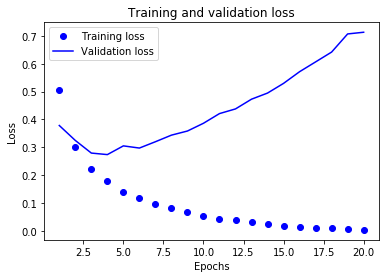

In [20]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

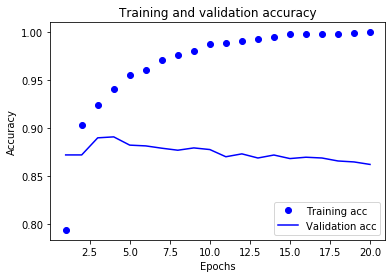

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

So, yeah, overfitting - after about the fourth epoch, we end up going the wrong direction w/ validation loss and validation accuracy. More in ch4, apparently.

What if we do a new model w/ the same configuration and only four epochs. (Don't like the duplication here, but am just following along for now, so I can get to dinner.)

In [28]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
#model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512)

results = model.evaluate(x_test, y_test)

results

Epoch 1/4
25000/25000 [==============================] - 1s 59us/step - loss: 0.4646 - accuracy: 0.8244
Epoch 2/4
25000/25000 [==============================] - 1s 56us/step - loss: 0.2620 - accuracy: 0.9086
Epoch 3/4
25000/25000 [==============================] - 1s 56us/step - loss: 0.2004 - accuracy: 0.9294
Epoch 4/4
25000/25000 [==============================] - 3s 113us/step


[0.29558979269981384, 0.8834800124168396]

# And use the model just for prediction

In [29]:
model.predict(x_test)

array([[0.13466676],
       [0.9992532 ],
       [0.7371012 ],
       ...,
       [0.08839078],
       [0.0617633 ],
       [0.513008  ]], dtype=float32)